### Import Library

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.callbacks import EarlyStopping
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Load Data

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/Glucofy-Team/Glucofy-Machine-Learning/main/data/(modified)%20nutrition%20food%20dataset.csv')
data

,category,name,glycemic_index,glycemic_load,calories (kcal),proteins (g),carbohydrates (g),fats (g)
0,Other,Yeast,35.0,6.3,105.0,8.0,18.0,1.9
1,Other,Brewer’s yeast,35.0,0.0,75.0,12.7,0.0,2.7
2,Other,Maltodextrin,95.0,94.0,380.0,0.0,99.0,0.0
3,Other,Palm pulp,20.0,1.2,354.0,3.4,6.2,33.5
4,Other,Omelette,49.0,7.3,210.0,14.0,15.0,2.1
...,...,...,...,...,...,...,...,...
581,Baked products,Pumpernickel Bread,45.0,21.6,250.0,9.0,48.0,3.1
582,Baked products,Rice Bread,70.0,48.0,306.0,6.3,68.6,0.7
583,Baked products,Bran bread,65.0,29.4,227.0,7.0,45.2,1.3
584,Baked products,Pumpkin bread,40.0,17.0,211.0,5.5,42.6,2.4


**Correlation Matrix**

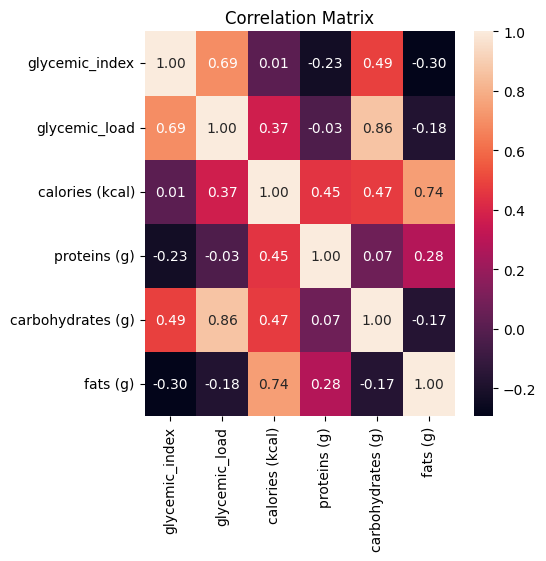

In [ ]:
correlation_matrix = data[['glycemic_index', 'glycemic_load', 'calories (kcal)', 'proteins (g)', 'carbohydrates (g)', 'fats (g)']].corr()

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### Preprocessing Data

- Separate numeric features and target variables.

In [ ]:
numeric_features = ['calories (kcal)', 'proteins (g)', 'carbohydrates (g)', 'fats (g)']
X = data[numeric_features]
y_gi = data['glycemic_index']

- Split the data into training and test sets.

In [ ]:
X_train, X_test, y_gi_train, y_gi_test = train_test_split(X, y_gi, test_size=0.1, random_state=42)

- Standardize the data to ensure the input features are balanced.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Glycemic Index Prediction

In [ ]:
baseline_pred = np.mean(y_gi_train)
baseline_loss = np.mean(np.abs(y_gi_test - baseline_pred))
print(f'Baseline MAE Loss: {baseline_loss}')

Baseline MAE Loss: 21.54964139838549


#### Linear Regression

In [ ]:
regression = LinearRegression()
regression_gi = regression.fit(X_train_scaled, y_gi_train)

In [ ]:
def model_evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)

    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_Score = metrics.r2_score(y_test, y_pred)

    return MAE, MSE, RMSE, R2_Score

In [ ]:
reg_mae, reg_mse, reg_rmse, reg_r2 = model_evaluation(regression_gi, X_test_scaled, y_gi_test)

In [ ]:
regression_gi_df = pd.DataFrame([[reg_mae, reg_mse, reg_rmse, reg_r2]],
                                index=['Linear Reg.'],
                                columns=['MAE', 'MSE', 'RMSE' ,'R2-Score'])

regression_gi_df

,MAE,MSE,RMSE,R2-Score
Linear Reg.,15.108708,328.698758,18.130051,0.506492


#### Decision Tree

In [ ]:
tree_regressor = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

tree_regressor.fit(X_train_scaled, y_gi_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                      random_state=42)

In [ ]:
tree_mae, tree_mse, tree_rmse, tree_r2 = model_evaluation(tree_regressor, X_test_scaled, y_gi_test)

tree_gi_df = pd.DataFrame([[tree_mae, tree_mse, tree_rmse, tree_r2]],
                                index=['Decision Tree'],
                                columns=['MAE', 'MSE', 'RMSE' ,'R2-Score'])

tree_gi_df

,MAE,MSE,RMSE,R2-Score
Decision Tree,13.877475,336.376953,18.340582,0.494964


#### Support Vector Regression

In [ ]:
svr_regressor = SVR(kernel='rbf', C=30.0, epsilon=0.01)
svr_regressor.fit(X_train_scaled, y_gi_train)

SVR(C=30.0, epsilon=0.01)

In [ ]:
svr_mae, svr_mse, svr_rmse, svr_r2 = model_evaluation(svr_regressor, X_test_scaled, y_gi_test)

svr_gi_df = pd.DataFrame([[svr_mae, svr_mse, svr_rmse, svr_r2]],
                                index=['SVR'],
                                columns=['MAE', 'MSE', 'RMSE' ,'R2-Score'])

svr_gi_df

,MAE,MSE,RMSE,R2-Score
SVR,12.715426,269.590471,16.41921,0.595237


#### Neural Network

In [ ]:
def create_nn_model_gi():

    model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(len(numeric_features),)),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation='relu')
    ])

    return model

In [ ]:
def adjust_learning_rate():

    model = create_nn_model_gi()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))

    optimizer = tf.keras.optimizers.Adam()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=['mae'])

    history = model.fit(X_train_scaled, y_gi_train, epochs=100, callbacks=[lr_schedule], verbose=0)

    return history

In [ ]:
lr_history_gi = adjust_learning_rate()

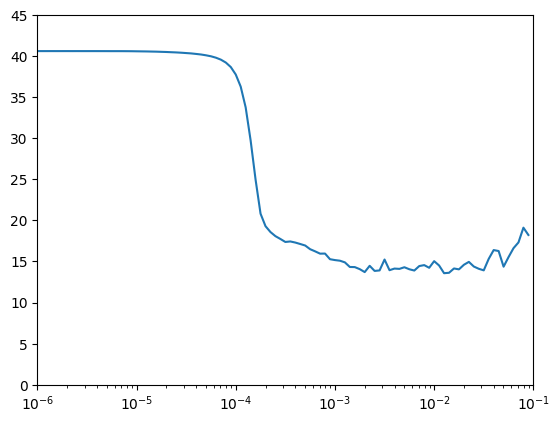

In [ ]:
plt.semilogx(lr_history_gi.history['lr'], lr_history_gi.history['loss'])
plt.axis([1e-6, 1e-1, 0, 45])
plt.show()

In [ ]:
nn_model = create_nn_model_gi()
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=7e-3), loss=tf.keras.losses.Huber(), metrics=['mae'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_mae', patience=10, verbose=1, restore_best_weights=True)

In [ ]:
nn_model.fit(X_train_scaled, y_gi_train, epochs=100, validation_data=(X_test_scaled, y_gi_test), verbose=2, callbacks=[early_stopping])

Epoch 1/100
17/17 - 2s - loss: 30.6138 - mae: 31.1080 - val_loss: 23.9334 - val_mae: 24.4309 - 2s/epoch - 118ms/step
Epoch 2/100
17/17 - 0s - loss: 19.2929 - mae: 19.7868 - val_loss: 16.0411 - val_mae: 16.5319 - 77ms/epoch - 5ms/step
Epoch 3/100
17/17 - 0s - loss: 17.4684 - mae: 17.9631 - val_loss: 16.5927 - val_mae: 17.0771 - 75ms/epoch - 4ms/step
Epoch 4/100
17/17 - 0s - loss: 16.6182 - mae: 17.1128 - val_loss: 16.4001 - val_mae: 16.8783 - 74ms/epoch - 4ms/step
Epoch 5/100
17/17 - 0s - loss: 15.6377 - mae: 16.1247 - val_loss: 15.0526 - val_mae: 15.5322 - 60ms/epoch - 4ms/step
Epoch 6/100
17/17 - 0s - loss: 15.2036 - mae: 15.6925 - val_loss: 13.9897 - val_mae: 14.4524 - 94ms/epoch - 6ms/step
Epoch 7/100
17/17 - 0s - loss: 14.6986 - mae: 15.1711 - val_loss: 14.3514 - val_mae: 14.8226 - 75ms/epoch - 4ms/step
Epoch 8/100
17/17 - 0s - loss: 14.8537 - mae: 15.3323 - val_loss: 14.1901 - val_mae: 14.6457 - 83ms/epoch - 5ms/step
Epoch 9/100
17/17 - 0s - loss: 14.5026 - mae: 14.9863 - val_loss

In [ ]:
gi_loss, gi_mae = nn_model.evaluate(X_test_scaled, y_gi_test, verbose=0)
print("Glycemic Index Model MAE:", gi_mae)

Glycemic Index Model MAE: 12.2490873336792


In [ ]:
y_gi_prediction = nn_model.predict(X_test_scaled)

print('Predicted GI values: ', [f'{val[0]:.2f}' for val in y_gi_prediction[:30]])
print('True GI values:      ', [f'{val:.2f}' for val in y_gi_test[:30]])

2/2 [==============================] - 0s 6ms/step
Predicted GI values:  ['36.90', '67.68', '36.93', '52.59', '0.00', '56.98', '35.42', '38.63', '37.18', '33.53', '46.22', '29.63', '56.28', '28.44', '58.10', '0.00', '6.83', '55.75', '0.00', '47.02', '48.94', '25.73', '73.90', '51.13', '44.16', '38.19', '27.25', '57.61', '58.59', '23.97']
True GI values:       ['60.00', '95.00', '45.00', '60.00', '0.00', '70.00', '47.00', '21.00', '40.00', '30.00', '70.00', '50.00', '25.00', '25.00', '30.00', '0.00', '0.00', '65.00', '30.00', '65.00', '50.00', '15.00', '95.00', '51.00', '50.00', '50.00', '30.00', '45.00', '70.00', '20.00']


### Compare Model

In [ ]:
mae_dict = {
    'Linear Regression': reg_mae,
    'Decision Tree': tree_mae,
    'SVR': svr_mae,
    'Neural Network': gi_mae
}

best_model = min(mae_dict, key=mae_dict.get)

print("Model with lowest MAE:", best_model)
print("MAE: ", mae_dict[best_model])

Model with lowest MAE: Neural Network
MAE:  11.37283706665039
